In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import itertools
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def cat2num_cv(train, test, groupby, resp, func='mean', cv=5):
    train_df = None
    index = list(range(train.shape[0]))
    np.random.seed(111)
    np.random.shuffle(index)
    for i in range(cv):
        visible_index = index[int((i*train.shape[0])/cv):int(((i+1)*train.shape[0])/cv)]
        blind_index = list(set(index).difference(visible_index))
        visibletrain = train.iloc[visible_index]
        blindtrain = train.iloc[blind_index]
        
        grp = getattr(blindtrain.groupby(groupby)[resp], func)().reset_index()
        #grp = grp.rename(columns={resp:groupby+'_num_cv'})
        temp = pd.merge(visibletrain.reset_index(), grp,
                        suffixes=('','_avg'),
                        how='left',
                        on=groupby).set_index('index')
        if train_df is None:
            train_df = temp
        else:
            train_df = pd.concat([train_df, temp])
        del temp

        
    grp_whole = getattr(train.groupby(groupby)[resp], func)().reset_index()
    #grp_whole = grp_whole.rename(columns={resp:groupby+'_num_cv'})
    test_df = pd.merge(test.reset_index(), grp_whole,
                           suffixes=('','_avg'),
                           how='left',
                           on=groupby).set_index('index')
   
    train_df.loc[:,groupby] = train_df[resp+'_avg']
    train_df.drop(resp+'_avg', axis=1, inplace=True)
    test_df.loc[:,groupby] = test_df[resp]
    test_df.drop(resp, axis=1, inplace=True)
     
    return train_df, test_df

/opt/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Read and select class 1 data, then save it.

In [7]:
data = pd.read_csv('../../../data/pnc/inbound/clv_lc_201705.csv')
data_c1 = data[data.class_modal == 1]
data_c1.to_csv('data_c1.csv', index=False)

In [2]:
data = pd.read_csv('data_c1.csv')

## Cleaning 'zip_code' and replacing with LAT and LNG

Check possible number of digits in zip_code

In [3]:
np.unique(data.zip_code[~data.zip_code.isnull()].apply(lambda x: len(str(int(x)))))

array([1, 3, 4, 5, 7, 8, 9])

Check samples with a specific number of digits in zip_code

In [4]:
nb_dig = 1    # 3, 4, 5, 7, 8, 9

ind = data.zip_code.apply(lambda x: len(str(int(x))) if ~np.isnan(x) else 0) == nb_dig
print(data.loc[ind,['zip_code','dma','market_clv']])

        zip_code  dma        market_clv
70647        0.0  NaN  Out of Footprint
76373        0.0  NaN  Out of Footprint
170413       0.0  NaN  Out of Footprint


Extract the right zip_code's

In [5]:
zipcode = data.zip_code.values

for i, z in enumerate(zipcode):
    if not np.isnan(z):
        l = len(str(int(z)))
        if l == 7:
            zipcode[i] = int(str(int(z))[:3])
        elif l == 8:
            zipcode[i] = int(str(int(z))[:4])
        elif l == 9:
            zipcode[i] = int(str(int(z))[:5])
        elif l == 1:
            zipcode[i] = np.nan
            
data.zip_code.head()

0     7065.0
1    17011.0
2    15015.0
3    40206.0
4    42701.0
Name: zip_code, dtype: float64

In [6]:
zip_file = pd.read_csv('zip.csv')
zip_file['zip_code'] = zip_file.ZIP.astype('float64')
zip_file.drop('ZIP', axis=1, inplace=True)
data = data.merge(zip_file, how='left', on='zip_code')

In [7]:
data.head()

,hh_id,rlb_location_key,time_period,rcb_consumer_hh,core_hh,wmg_hh,acorn_hh,hh_agr_type,core_agr_type,cls_dym_hh,...,od_late_fee,dc_flag,cc_flag,class_1,class_2,class_3,class_4,class_modal,LAT,LNG
0,2,2000222001002153429,2017-05-31,1,1,0,1,1E,1E,0,...,0,0,0,0.989166,0.010783,3.856100e-07,5.051460e-05,1,40.607152,-74.280531
1,5,2000222001005672586,2017-05-31,1,1,0,1,1E,1E,0,...,0,0,0,0.957647,0.042347,6.811310e-07,4.782460e-06,1,40.234830,-76.928846
2,8,2000269000000000535,2017-05-31,1,1,1,1,1E,1E,0,...,0,0,0,0.999726,0.000265,6.349970e-07,9.298830e-06,1,40.637248,-80.081101
3,11,2000269000000000622,2017-05-31,1,1,0,1,1E,1E,0,...,0,1,0,0.627414,0.372583,3.305190e-06,4.192430e-11,1,38.260083,-85.704721
4,12,2000269000000000631,2017-05-31,1,1,0,1,1E,1E,0,...,0,0,0,0.999350,0.000620,2.330320e-07,2.985770e-05,1,37.703686,-85.837111


List all available responses (labels)

In [8]:
col_res = [
    'dd_hh',
    'sv_hh',
    'mm_hh',
    'cd_hh',
    'ir_hh',
    'pp_hh',
    'cc_hh',
    'mt_hh',
    'heil_hh',
    'heloc_hh',
    'pil_hh',
    'ploc_hh',
    'auto_hh',
    'sl_hh',
    'iil_hh',
    'sdin_hh',
    'dc_flag',
    #'cc_flag',
    'od_late_fee']

Check correlation between responses.

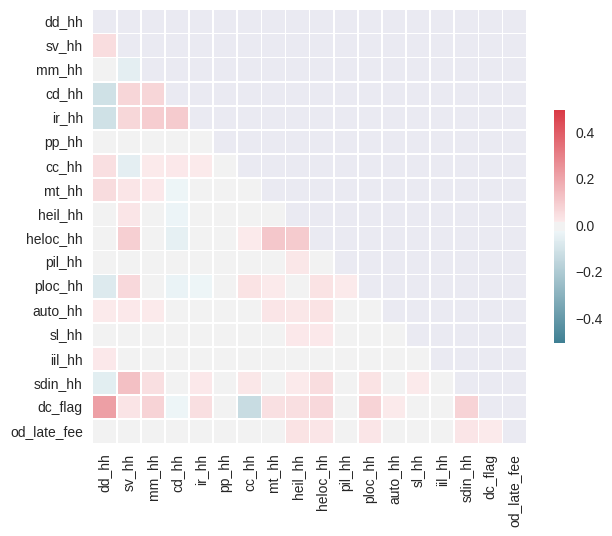

In [9]:
corr = data[col_res].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
# col_drop = [
#  'hh_id',
#  'rlb_location_key',
#  'time_period',
#  'rcb_consumer_hh',
#  'cls_dym_hh',
#  'churn_hh',
#  'cc_num_pur_ls',
#  'cc_flag',
#  'class_modal']

In [11]:
features = [
    'tch_dmail_impr_lag',
    'tch_email_impr_lag',
    'cim_olb_impr_lag',
    'cim_ccc_impr_lag', 
    'cim_atm_impr_lag', 
    'cim_tel_impr_lag',
    'cim_pli_impr_lag',
    'cim_plo_impr_lag',
    'hh_agr_type',
    'new_hh_12m',
    'rel_tenure', 'age_hh', 'age_grp_4L', 'inc_code_hh', 'inc_grp_3L', 
    'consumer_segment', 'psycle_code_ne', 'lifestage', 'dma', 'footprint_clv', 'market_clv', 'LAT', 'LNG']

### Dummy encoding

data_green = data[features]
col_dummy = ['hh_agr_type', 'age_grp_4L', 'inc_grp_3L', 'consumer_segment', 'lifestage']
        
data_green = pd.get_dummies(data_green, columns=col_dummy, drop_first=True)

Rename some dummy features for xgboost.

In [12]:
col_rename = ['consumer_segment', 'age_grp_4L', 'inc_grp_3L']

dict_rename = dict()
for i, f in enumerate(col_rename):
    keys = [f+'_'+item for item in data[f].value_counts().index]
    values = [f+'_'+''.join(filter(lambda ch: ch not in " []<", item)) for item in data[f].value_counts().index]
    dict_rename = {**dict_rename, **dict(zip(keys, values))}
    
data_green.rename(columns=dict_rename, inplace=True)

## Feature engineering

In [394]:
data_green['inc_x_dma'] = data['inc_code_hh'].astype(str) + '+++' + data['dma'].astype(str)
data_green['inc_x_age'] = data['inc_code_hh'].astype(str) + '+++' + data['age_grp_4L'].astype(str)
data_green['LAT_LNG'] = round(data.LAT).astype(str) + '+++' + round(data.LNG).astype(str)

In [395]:
data_green['tch_lag_sum'] = data_green.tch_dmail_impr_lag + data_green.tch_email_impr_lag
data_green['cim_lag_sum'] = data_green.cim_olb_impr_lag + data_green.cim_ccc_impr_lag + data_green.cim_atm_impr_lag + \
                            data_green.cim_tel_impr_lag + data_green.cim_pli_impr_lag + data_green.cim_plo_impr_lag
data_green['lag_sum'] = data_green['tch_lag_sum'] + data_green['cim_lag_sum']

In [384]:
data_green['tenure_ratio'] = data_green.rel_tenure / (data_green.age_hh * 12)

In [396]:
data_green['dmail_ratio'] = data_green.tch_dmail_impr_lag / (data_green.tch_lag_sum+0.001)
data_green['atm_ratio'] = data_green.cim_atm_impr_lag / (data_green.cim_lag_sum+0.001)
data_green['olb_ratio'] = data_green.cim_olb_impr_lag / (data_green.cim_lag_sum+0.001)

data_green['dmail_total_ratio'] = data_green.tch_dmail_impr_lag / (data_green['lag_sum'] +0.001)
data_green['email_total_ratio'] = data_green.tch_email_impr_lag / (data_green['lag_sum'] +0.001)
data_green['atm_total_ratio'] = data_green.cim_atm_impr_lag / (data_green['lag_sum'] +0.001)
data_green['olb_total_ratio'] = data_green.cim_olb_impr_lag / (data_green['lag_sum'] +0.001)

In [261]:
# import math
# def rotation_x(row, alpha):
#     x = row['LAT']
#     y = row['LNG']
#     return x*math.cos(alpha) + y*math.sin(alpha)
# def rotation_y(row, alpha):
#     x = row['LAT']
#     y = row['LNG']
#     return y*math.cos(alpha) - x*math.sin(alpha)
# def add_rotation(degrees, df):
#     namex = 'rot'+str(degrees)+'_X'
#     namey = 'rot'+str(degrees)+'_Y'
#     df['num_'+namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
#     df['num_'+namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)
#     return df

# for angle in [15,30,45,60]:
#     data_green = add_rotation(angle, data_green)

In [424]:
data_green.columns

Index(['tch_dmail_impr_lag', 'tch_email_impr_lag', 'cim_olb_impr_lag',
       'cim_ccc_impr_lag', 'cim_atm_impr_lag', 'cim_tel_impr_lag',
       'cim_pli_impr_lag', 'cim_plo_impr_lag', 'new_hh_12m', 'rel_tenure',
       'age_hh', 'inc_code_hh', 'psycle_code_ne', 'dma', 'footprint_clv',
       'market_clv', 'LAT', 'LNG', 'hh_agr_type_2N', 'hh_agr_type_4ND',
       'age_grp_4L_b', 'age_grp_4L_c', 'age_grp_4L_d', 'inc_grp_3L_b',
       'inc_grp_3L_c', 'segment_Upper', 'segment_Lower', 'segment_Beginners',
       'lifestage_F2', 'lifestage_F3', 'lifestage_F4', 'lifestage_M1',
       'lifestage_M2', 'lifestage_M3', 'lifestage_M4', 'lifestage_M5',
       'lifestage_Y1', 'lifestage_Y2', 'lifestage_Y3', 'lifestage_ZZ'],
      dtype='object')

## Start model fitting

In [13]:
def xgb_single_clv(data_raw, data_green, label_name, save_X_y=True, n_iter=None, pos_weight=1):
    y = data_raw[label_name]
    X = data_green
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=666)

    # Categorical to numerical
    train = pd.concat([X_trn, y_trn], axis=1)
    test = X_tst
    col_c2n = ['dma', 'market_clv', 'inc_x_dma', 'inc_x_age', 'LAT_LNG']
    for col in col_c2n:
        train, test = cat2num_cv(train, test, col, label_name, func='mean', cv=5)
        
    X_trn = train.drop(label_name, axis=1)
    y_trn = train[label_name]
    X_tst = test
    y_tst = y_tst[test.index]

    print('====================')
    print('Label:', label_name)
    print('--------------------')
    
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.01
    param['eval_metric'] = 'auc'
    param['max_depth'] = 6
    param['min_child_weight'] = 3
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['gamma'] = 0
    param['base_score'] = np.mean(y_trn)
    param['silent'] = True
    param['scale_pos_weight'] = pos_weight
    # param['seed'] = 100
    
    trn = xgb.DMatrix(X_trn, label=y_trn)
    if n_iter == None:
        print('Begin tunning parameters ...')
        res = xgb.cv(param, trn, nfold=4, 
                     stratified=True, num_boost_round=5000, early_stopping_rounds=50,
                     verbose_eval=None, show_stdv=True, metrics={'auc'}, maximize=True)
        min_index = np.argmax(res['test-auc-mean'])
        print('Done! The best iteration number is', min_index)
    else:
        min_index = n_iter
        print('The pre-selected iteration number is', min_index)
    print('Begin fitting model ...')
    tst = xgb.DMatrix(X_tst, label=y_tst)
    model = xgb.train(param, trn, min_index, [(trn,'train'), (tst, 'test')], verbose_eval=None)

    pred = model.predict(tst)
    print('Done! Test AUC:', roc_auc_score(y_tst, pred))
    print('Feature importance:')
    # fig, ax = plt.subplots(1,1,figsize=(8,10))
    # xgb.plot_importance(model, height=0.5, ax=ax)

    fea_imp = sorted(model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)
    print(fea_imp)
    
    if save_X_y:
        X_trn.to_csv('data/'+label_name+'_X_trn.csv', index=False)
        X_tst.to_csv('data/'+label_name+'_X_tst.csv', index=False)
        y_trn.to_csv('data/'+label_name+'_y_trn.csv', index=False)
        y_tst.to_csv('data/'+label_name+'_y_tst.csv', index=False)
    
    return pred, model, fea_imp

In [400]:
pred_list_lag = [0]*len(col_res)
model_list_lag = [0]*len(col_res)
imp_list_lag = [0]*len(col_res)
for i, col in enumerate(col_res):
    pred_list_lag[i], model_list_lag[i], imp_list_lag[i] = xgb_single_clv(data, data_green, col)

Label: dd_hh
--------------------
Begin tunning parameters ...
Done! The best iteration number is 3106
Begin fitting model ...
Done! Test AUC: 0.813061008457
Feature importance:
[('rel_tenure', 16905), ('LNG', 13509), ('LAT', 13206), ('age_hh', 10470), ('inc_x_dma', 9699), ('inc_x_age', 8860), ('LAT_LNG', 7886), ('dma', 7169), ('psycle_code_ne', 5949), ('market_clv', 5642), ('inc_code_hh', 3738), ('lag_sum', 2425), ('email_total_ratio', 1873), ('cim_lag_sum', 1581), ('olb_total_ratio', 1539), ('olb_ratio', 1392), ('segment_Lower', 1331), ('dmail_total_ratio', 1286), ('segment_Upper', 1017), ('tch_email_impr_lag', 992), ('dmail_ratio', 921), ('lifestage_M2', 868), ('tch_lag_sum', 858), ('cim_olb_impr_lag', 807), ('atm_total_ratio', 733), ('cim_pli_impr_lag', 627), ('cim_plo_impr_lag', 621), ('atm_ratio', 594), ('inc_grp_3L_b', 583), ('cim_tel_impr_lag', 455), ('tch_dmail_impr_lag', 431), ('footprint_clv', 374), ('cim_atm_impr_lag', 373), ('lifestage_M3', 371), ('lifestage_M4', 293), ('l

## Check correlations between features

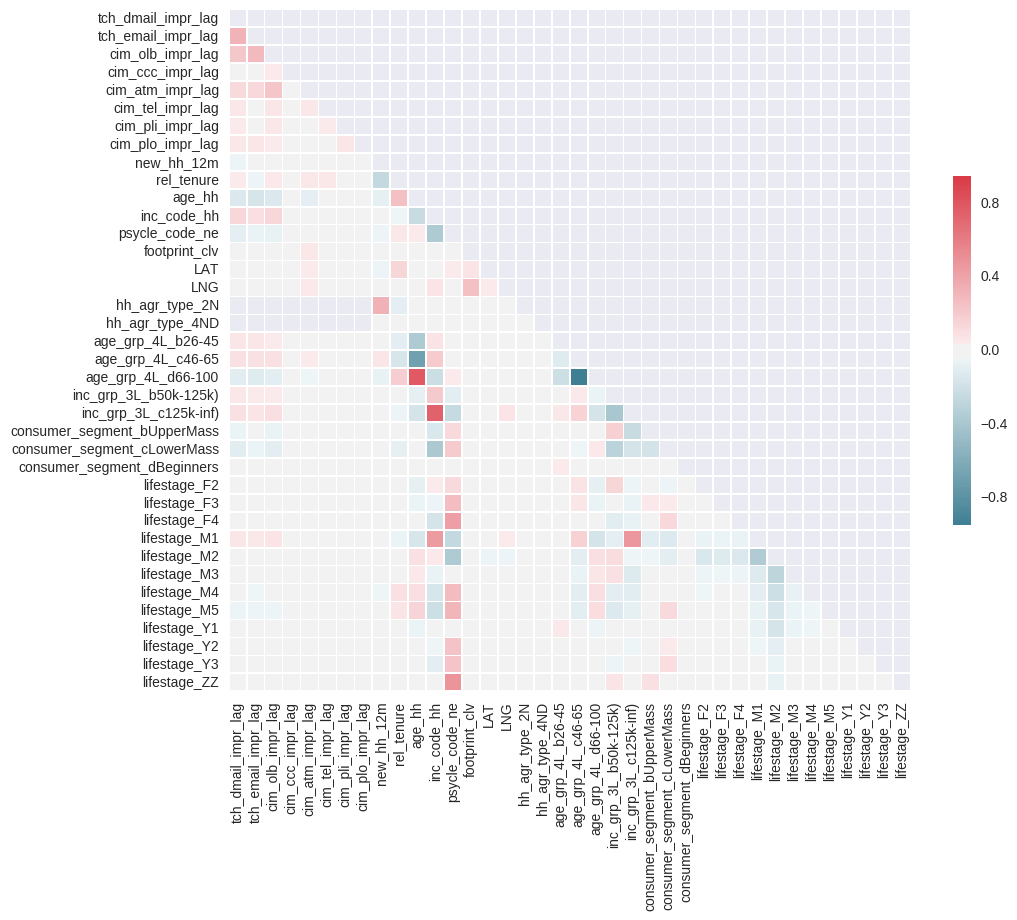

In [14]:
corr_g = data_green.corr()
mask = np.zeros_like(corr_g, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_g, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Check the correlation between responses and features

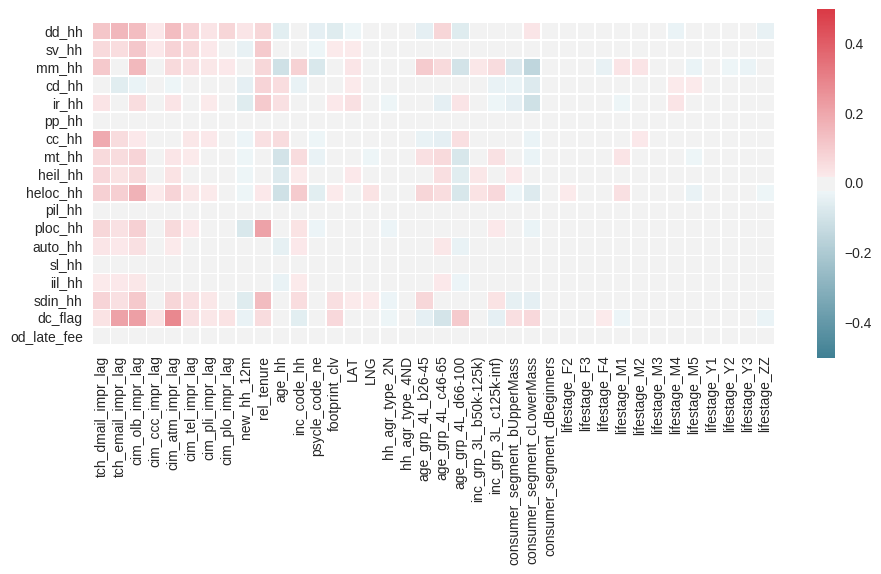

In [15]:
corr_all = pd.concat([data.loc[:,col_res], data_green], axis=1).corr()
# mask = np.zeros_like(corr_all, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_all.iloc[18:,:18].T, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Output lift scores 

In [401]:
for i, label_name in enumerate(col_res):
    y_trn = pd.read_csv('data/'+label_name+'_y_trn.csv', names=[label_name])
    y_tst = pd.read_csv('data/'+label_name+'_y_tst.csv', names=[label_name])
    
    pred = pred_list[i]
    pred_sort = pd.DataFrame(pred, columns=['pred']).sort_values('pred', ascending=False)
    
    gp_size = round(len(pred)/10)
    arrs = [np.array([i]*gp_size) for i in range(9)] + [np.array([9]*(len(pred)-gp_size*9))]
    gp_ind = np.concatenate(arrs)
    
    pred_sort = pd.DataFrame({'pred_sort':pred_sort['pred'], 'gp_ind':gp_ind})
    
    obs_prob = [np.mean(y_tst.reset_index().ix[pred_sort.loc[gp_ind == i].index][label_name]) for i in range(10)]
    output = pd.DataFrame({'pred_prob':pred_sort.groupby('gp_ind').mean().pred_sort.values, 'obs_prob':obs_prob}, index=range(10))
    output['obs_cum'] = [np.mean(output.obs_prob[:i]) for i in range(1,11)]
    output['lift'] = output['obs_cum']/output['obs_cum'].iloc[-1]
    output = output[['pred_prob','obs_prob','obs_cum','lift']]
    
#     output.style.format({
#     'obs_prob': '{:.1%}'.format,
#     'pred_prob': '{:.1%}'.format,
#     'obs_cum': '{:.1%}'.format,
#     'lift': '{:.3}'.format
#     })
    print('====================')
    print('Label:', label_name)
    print('--------------------')
    print(output)

Label: dd_hh
--------------------
   pred_prob  obs_prob   obs_cum      lift
0   0.993561  0.994933  0.994933  1.196306
1   0.983184  0.984799  0.989866  1.190213
2   0.968226  0.965290  0.981674  1.180363
3   0.943992  0.940714  0.971434  1.168051
4   0.901291  0.908538  0.958855  1.152926
5   0.845736  0.850013  0.940714  1.131114
6   0.784860  0.807702  0.921713  1.108266
7   0.723828  0.743856  0.899481  1.081534
8   0.646735  0.647327  0.871464  1.047847
9   0.492292  0.473538  0.831671  1.000000
Label: sv_hh
--------------------
   pred_prob  obs_prob   obs_cum      lift
0   0.243457  0.233595  0.233595  2.627557
1   0.142055  0.145174  0.189384  2.130259
2   0.110729  0.115277  0.164682  1.852399
3   0.091745  0.093995  0.147010  1.653622
4   0.078233  0.080314  0.133671  1.503578
5   0.066971  0.071193  0.123258  1.386449
6   0.056526  0.056245  0.113685  1.278766
7   0.046053  0.042817  0.104826  1.179123
8   0.034237  0.031923  0.096726  1.088007
9   0.019259  0.018486  0.088